# Ipython Cluster heat budget calculations #

Layers calculater is a a C- wrapped complex function that splits up the model grid into 300 levels and puts into 42 discrete set temperature bins.  

This is computationally very slow. ~ 30 mins per variable so to generate my figures this will take 4 hours. I suggest 4-6 processers to reduce this to under 1 hour.

In [1]:
from IPython import parallel
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pylab import *
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
import SG as SG
import layers_calc_numba
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils
%matplotlib inline

start cluster on machine 

ipcluster start --profile=profile name -n 6


In [2]:
rc = parallel.Client('/noc/users/hb1g13/.ipython/profile_typhoon/security/ipcontroller-client.json')
dv = rc[:]
rc.ids

[0, 1, 2, 3, 4, 5]

In [3]:
%%px
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pylab import *
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
import SG as SG
import layers_calc_numba
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils

In [4]:
# Some parameters
Full = 'N'  # 9 Pannels isn't ideal for presentations N option give 4 plots

In [5]:
if Full == 'N':
    tau = ['3', '300', '3000', 'Closed']
elif Full == 'Extremes':
    tau = ['3','Closed']
else:
    tau = ['3', '10', '30', '100', '300',
           '1000', '3000', '10000', 'Closed']
Figletter = ['a) ','b) ','c) ','d) ','e)','f)','g)','h)','j)']
# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'daynokpp/PSI.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)

## Outline of code: ##

**Probability deffined layers**

* mask out undefined layers
* find the first value layer probability = 1
* some layers are very think so check there isn't a crazy step - ajust if so!
* use depth matix to deffine diabatic layer depth

**ROC at diabatic layer depth**

* As above and take the ROC at this depth
* One extra clause: check a big surface wind driven circulation isnt being picked up!

** Now add in Ty multiplication **

The neatest ROC calculated is a long DDL depth so lets try that first.

1. Ty from remapped layers temp 
2. Ty from THETA

Ty from THETA
Try just at surface values - theoreticall the same through out diabatic layer ;)

More thorough mapp Ty back to layers space and take value at diabatic layer

** Remap explicit diabatic to layers and integrate DDL to surface ** 

\begin{equation}
\int_{-dl}^0 \frac{\partial \left( \overline{w'T'}-\overline{v'T'}S_p \right)}{\partial z }. \mathrm{d}z = DEs \, \, |_{-dl}
\end{equation}

In [6]:
%%px
c1 = utils.ChannelSetup(output_dir=str('/noc/msm/scratch/students/hb1g13/Mobilis'+'/3daynokpp/'))
c2 = utils.ChannelSetup(output_dir=str('/noc/msm/scratch/students/hb1g13/Mobilis'+'/300daynokpp/'))
c3 = utils.ChannelSetup(output_dir=str('/noc/msm/scratch/students/hb1g13/Mobilis'+'/3000daynokpp/'))
c4 = utils.ChannelSetup(output_dir=str('/noc/msm/scratch/students/hb1g13/Mobilis'+'/Closeddaynokpp/'))

\begin{equation}
S_p = \frac{\frac{\partial T}{\partial y}}{\frac{\partial T}{\partial z}} 
\end{equation}

so

\begin{equation}
S_p = \frac{\partial z}{\partial y} = \frac{Th}{\partial y}
\end{equation}

where Th is layer thickness.


substiuting back in to diabatic eddies deffiniton

\begin{equation}
DE = \overline{w'T'} - \overline{v'T'}.\frac{Th}{\partial y}
\end{equation}

or 

\begin{equation}
DE = \overline{w'T'} - \Psi ^*\frac{\partial T}{Th}.\frac{Th}{\partial y}
\end{equation}

\begin{equation}
DE = \overline{w'T'} - \Psi ^*\frac{\partial T}{Th}.\frac{Th}{\partial y}
\end{equation}

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:65: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


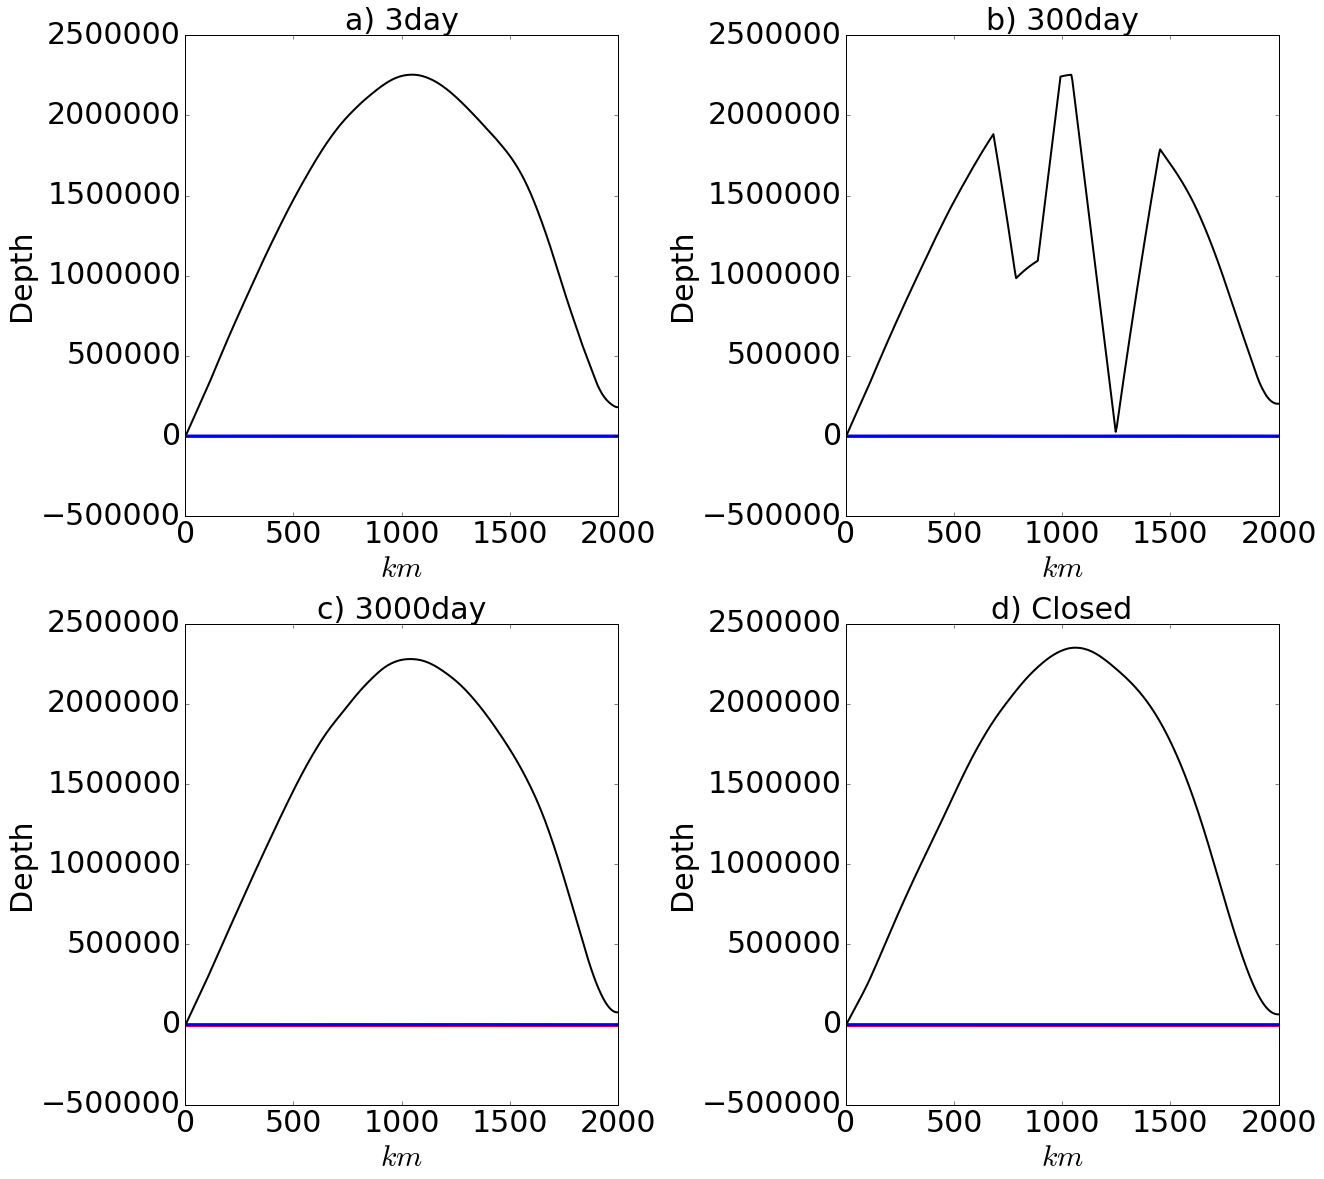

In [51]:
fig = plt.figure(figsize=(18.5, 16.5))
for i in range(len(Runs)):
    
    if i==0:
        %px g = layers_calc_numba.LayersComputer(c1)
        %px c= c1
    elif i ==1:
        %px g = layers_calc_numba.LayersComputer(c2)
        %px c = c2
    elif i==2:
        %px g = layers_calc_numba.LayersComputer(c3)
        %px c = c3
    elif i==3:
        %px g = layers_calc_numba.LayersComputer(c4)
        %px c = c4
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # Calculate cartesian diabatic eddies 
     # PLOT PANNELS
    %px CellVol = c.rac * np.tile(c.dzf, (c.Nx, c.Ny, 1)).T

    # load V, W, T bar
    # put everything on the C Grid
    %px VT = (c.mnc('Tav_VT.nc', 'VVELTH'))
    %px WT = (c.mnc('Tav_VT.nc', 'WVELTH'))
    %px Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc', 'THETA'))
    %px Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc', 'THETA'))
    %px V = (c.mnc('Tav.nc', 'VVEL'))
    %px W = (c.mnc('Tav.nc', 'WVEL'))
    %px T = c.mnc('Tav.nc', 'THETA')
    %px npad = ((0, 1), (0, 0), (0, 0))
    %px W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    %px WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    %px VTbar = V * Tv
    %px WTbar = W * Tw
    %px VpTp = VT - VTbar
    %px WpTp = WT - WTbar
  
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)



    # ROC 
    psi = c.get_psi_iso()
    # Layer probability mask 
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI,PI<0.95)
    #psi = ma.masked_array(psi, PI < .98 )
    # Depths
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1],axis=0)[::-1]
    g = layers_calc_numba.LayersComputer(c)

    
    g = layers_calc_numba.LayersComputer(c)
    Ty = c.ddy_cgrid_centered(T)
        
 


    
    lvrho = g.compute_vflux()[0]
    V = lvrho.mean(axis=2)
    psi = -V.cumsum(axis=0)*c.Lx
    psied = c.vgrid_to_cgrid(c.get_psi_iso()) - psi
    
    
     
    dv.execute('A_local=g.interp_to_g1(c.wgrid_to_cgrid(WpTp),T)',block=True)
    wptp_l = dv.gather('A_local').get()[0]
    wptp_l = wptp_l.mean(axis=2)
    # Calculate diabatic layer depth and ROC 
    dTththdy =np.tile(c.layers_bounds[1::]-c.layers_bounds[0:-1],(c.Ny,1)).T/5000
    DE_l = wptp_l + (psied*dTththdy/(5000*c.Lx))
    # Find Max ROC and depth of diabatic layer
    
    DDL = np.zeros(len(c.yc)) 
    ROC = np.zeros(len(c.yc)) 

    DE_dl = np.zeros(len(c.yc)) 
    for jj in range(len(c.yc)):
        if ma.all(PI[:,jj]  == 1)  or np.all(psi[:,jj] == -0) or PI[:,jj].mask.all():
            continue
        indx = ma.nonzero(PI[:,jj]<1)[0]
        b = indx[np.nonzero(indx>3)[0]]
        if len(b)>=2 and (b[1]-b[0])>1:
            a = b[1]
        else:
            a = b[0]
        if a<41 and depths[a-1,jj] - depths[a,jj] > 150:
            a = a-1
        DDL[jj] = depths[a,jj]
        DE_dl[jj] = -DE_l[a,jj]

        if psi[a,jj]/10**6 > 1.0:
            a = a-1
        ROC[jj] = psi[a,jj]
    
 
    Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000 * 3985)
    ax = fig.add_subplot(2, 2, i+1)
    #p = plt.plot(c.yc/1000, SG.savitzky_golay(ROC,41,1)*SG.savitzky_golay(Ty,41,1), 'k', linewidth=2)
    #q = plt.plot(c.yc/1000, (Psipred/c.dzc[0])*10**6, 'r', linewidth=3)
    #r = plt.plot(c.yc/1000, (SG.savitzky_golay(ROC,41,1)*SG.savitzky_golay(Ty,41,1)-(Psipred/c.dzc[0])*10**6), 'b', linewidth=1)
    q = plt.plot(c.yc/1000, SG.savitzky_golay(DE_dl,21,1)*10**6,'b',linewidth=3)
    #plt.ylim(-1.5,1.5)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel(r'$km$', fontsize=30)
    ax.set_ylabel(r'Depth', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)

plt.tight_layout()

can also remap $\overline{WT}(y,T)$ $(\overline{W}\overline{T})(y,T)$ to calulate $\overline{w'T'}(y,T)$

In [ ]:
fig = plt.figure(figsize=(18.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    if i==0:
        %px c= c1
        %px g = layers_calc_numba.LayersComputer(c)
    elif i ==1:
        %px g = layers_calc_numba.LayersComputer(c2)
        %px c = c2
    elif i==2:
        %px g = layers_calc_numba.LayersComputer(c3)
        %px c = c3
    elif i==3:
        %px g = layers_calc_numba.LayersComputer(c4)
        %px c = c4
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # Calculate cartesian diabatic eddies 
     # PLOT PANNELS
    %px CellVol = c.rac * np.tile(c.dzf, (c.Nx, c.Ny, 1)).T

    # load V, W, T bar
    # put everything on the C Grid
    %px VT = c.vgrid_to_cgrid(c.mnc('Tav_VT.nc', 'VVELTH'))
    %px WT = (c.mnc('Tav_VT.nc', 'WVELTH'))
    %px V = c.vgrid_to_cgrid(c.mnc('Tav.nc', 'VVEL'))
    %px W = (c.mnc('Tav.nc', 'WVEL'))
    %px T = c.mnc('Tav.nc', 'THETA')
    %px npad = ((0, 1), (0, 0), (0, 0))
    %px W = c.wgrid_to_cgrid(np.pad(W, pad_width=npad, mode='constant', constant_values=0))
    %px WT = c.wgrid_to_cgrid(np.pad(WT, pad_width=npad, mode='constant', constant_values=0))
    dv.execute('A_local=g.interp_to_g1(g,VT,T)',block=True)
    VT_l = dv.gather('A_local').get()[0]
    dv.execute('A_local=g.interp_to_g1(g,WT,T)',block=True)
    WT_l = dv.gather('A_local').get()[0]
    dv.execute('A_local=g.interp_to_g1(g,V,T)',block=True)
    V_l = dv.gather('A_local').get()[0]
    dv.execute('A_local=g.interp_to_g1(g,W,T)',block=True)
    W_l = dv.gather('A_local').get()[0]
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
     
    WpTp_L = WT_l - W_l*g.glvl
    VpTp_L = VT_l - V_l*g.glvl
    # Calculate diabatic layer depth and ROC 
    
    # ROC 
    psi = c.get_psi_iso()
    # Layer probability mask 
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI,PI<0.95)
    #psi = ma.masked_array(psi, PI < .98 )
    # Depths
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1],axis=0)[::-1]
    
    D = WpTp_L - VpTp_L*th/5000
    # Find Max ROC and depth of diabatic layer
    DDL = np.zeros(len(c.yc)) 
    ROC = np.zeros(len(c.yc)) 
    TL = np.zeros(len(c.yc))
    DE_dl = np.zeros(len(c.yc)) 
    for jj in range(len(c.yc)):
        if ma.all(PI[:,jj]  == 1)  or np.all(psi[:,jj] == -0) or PI[:,jj].mask.all():
            continue
        indx = ma.nonzero(PI[:,jj]<1)[0]
        b = indx[np.nonzero(indx>3)[0]]
        if len(b)>=2 and (b[1]-b[0])>1:
            a = b[1]
        else:
            a = b[0]
        if a<41 and depths[a-1,jj] - depths[a,jj] > 150:
            a = a-1
        DDL[jj] = depths[a,jj]
        DE_dl[jj] = D[a,jj]
        TL[jj] = g.glvl[a-1]
        if psi[a,jj]/10**6 > 1.0:
            a = a-1
        ROC[jj] = psi[a,jj]
    Temp = c.mnc('Tav.nc','THETA').mean(axis=2)
    TLZ =(np.tile((TL+Temp[1,:])/2,(c.Nz,1)))
    TLy = c.ddy_cgrid_centered(TLZ)[0,:]
    Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000 * 3985)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000, SG.savitzky_golay(ROC,41,1), 'k', linewidth=2)
    q = plt.plot(c.yc/1000, (Psipred/c.dzc[0])*10**6, 'r', linewidth=3)
    #r = plt.plot(c.yc/1000, (SG.savitzky_golay(ROC,41,1)*SG.savitzky_golay(Ty,41,1)-(Psipred/c.dzc[0])*10**6), 'b', linewidth=1)
    q = plt.plot(c.yc/1000, -SG.savitzky_golay(DE_dl,21,1)/DDL*10**6,'b',linewidth=3)
    plt.ylim(-1.5,1.5)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel(r'$km$', fontsize=30)
    ax.set_ylabel(r'Depth', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)

plt.tight_layout()